Here we consider building a separate neural network for each element - does this perform better?

In [256]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['indices']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [260]:
# Load training data:
dat=np.load('/mnt/store1/oliverphilcox/TestPredictions6El.npz')
abun=dat.f.abundances
els=dat.f.elements
params=dat.f.params

First remove any data which couldn't be sampled. (These regions in parameter space will be excluded from the priors).

In [261]:
bitmap=np.ones(len(params),dtype=int)
for i,ab in enumerate(abun):
    if ab[0]==0:
        bitmap[i]=0

In [262]:
cut_params=params[np.where(bitmap==1)]
cut_abuns=abun[np.where(bitmap==1)]

Also remove any NaN points (just one point in the extremal edges of parameter space so unimportant). We'll also remove any timesteps for $t<2$ here.

In [263]:
good_index=np.where(np.isfinite(cut_abuns[:,0]))[0]#&(params[:,-1]>0.99)))[0]
cut_params2=cut_params[good_index]
cut_abuns2=cut_abuns[good_index]
good_index2=np.where(cut_params2[:,-1]>1.99)[0]
cut_params3=cut_params2[good_index2]
cut_abuns3=cut_abuns2[good_index2]

Normalize these parameters:

In [264]:
par_mean=np.mean(cut_params3,axis=0)
par_std=np.std(cut_params3,axis=0)
ab_mean=np.mean(cut_abuns3,axis=0)
ab_std=np.std(cut_abuns3,axis=0)

trainX=(cut_params3-par_mean)/par_std
trainY=(cut_abuns3-ab_mean)/ab_std

Only take a small subset for testing:

In [266]:
#indices=np.random.randint(0,len(trainX),100000)
#trainX=trainX[indices]
#trainY=trainY[indices]

Build neural net:

In [267]:
# Parameters
#neurons = 20
learning_rate = 0.05
epochs=200

In [268]:
el_index=0 # create network for zeroth element

n_train = len(trainX)

# Dimensions
dim_in = trainX.shape[1]
dim_out= 1#trainY.shape[1]

import torch
from torch.autograd import Variable


# Convert to torch variables
tr_input = Variable(torch.from_numpy(trainX)).type(torch.FloatTensor)
tr_output = Variable(torch.from_numpy(trainY[:,el_index].reshape(len(trainY),1)), requires_grad=False).type(torch.FloatTensor)

#tr_input = Variable(torch.from_numpy(testX[:5000])).type(torch.FloatTensor)
#tr_output = Variable(torch.from_numpy(testY[:5000,el_index].reshape(5000,1)), requires_grad=False).type(torch.FloatTensor)


Define the neural network model:

In [269]:
hidden_layer_1, hidden_layer_2 = 10, 40

def one_layer_model(neurons=10):
    model = torch.nn.Sequential(
        torch.nn.Linear(dim_in,neurons),
        torch.nn.Sigmoid(),
        torch.nn.Linear(neurons,dim_out)
    )
    return model


#two_layer = torch.nn.Sequential(
#    torch.nn.Linear(dim_in,hidden_layer_1),
#    torch.nn.Tanh(),
#    torch.nn.Linear(hidden_layer_1,hidden_layer_2),
#    torch.nn.Tanh(),
#    torch.nn.Linear(hidden_layer_2,dim_out)
#    )


Create a training function:

In [317]:
def train_neural_network(model,epochs = epochs,learning_rate = learning_rate,tr_output=tr_output):
    loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')

    # Use Adam optimizer with learning rate specified in parameter.py
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    
    # For loss records
    losslog = []
    epoch = []
    
    # Train neural network
    for i in range(epochs):
        pred_output = model(tr_input)
        loss = loss_fn(pred_output, tr_output)
        optimizer.zero_grad() # Initially zero gradient
        loss.backward() # Backpropagation
        optimizer.step() # Update via optimizer
        scheduler.step(loss) # Update learning rate

        if i % 10 ==0:
            losslog.append(loss.data[0])
            epoch.append(i)
        if i % 10==0:
            print("Training epoch %d of %d complete" %(i,epochs))
    
    # Convert weights to numpy arrays
    model_numpy = []
    for param in model.parameters():
        model_numpy.append(param.data.numpy())

    print("L1 Loss value is {}".format(losslog[-1]))
    
    plt.plot(epoch,losslog,label=learning_rate)
    plt.ylabel("L1 Loss value")
    plt.xlabel("Epoch")
    plt.title("Loss plot")
    plt.legend()
    plt.show()
    
    return model_numpy,epoch,losslog


Now train the network:



  0%|          | 0/6 [00:00<?, ?it/s]/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Training epoch 0 of 200 complete


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Training epoch 0 of 200 complete


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Training epoch 0 of 200 complete
Training epoch 0 of 200 complete


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Training epoch 0 of 200 complete
Training epoch 0 of 200 complete
Training epoch 10 of 200 complete
Training epoch 10 of 200 complete
Training epoch 10 of 200 complete
Training epoch 10 of 200 complete
Training epoch 10 of 200 complete
Training epoch 10 of 200 complete
Training epoch 20 of 200 complete
Training epoch 20 of 200 complete
Training epoch 20 of 200 complete
Training epoch 20 of 200 complete
Training epoch 20 of 200 complete
Training epoch 20 of 200 complete
Training epoch 30 of 200 complete
Training epoch 30 of 200 complete
Training epoch 30 of 200 complete
Training epoch 30 of 200 complete
Training epoch 30 of 200 complete
Training epoch 40 of 200 complete
Training epoch 30 of 200 complete
Training epoch 40 of 200 complete
Training epoch 40 of 200 complete
Training epoch 40 of 200 complete
Training epoch 40 of 200 complete
Training epoch 50 of 200 complete
Training epoch 50 of 200 complete
Training epoch 50 of 200 complete
Training epoch 40 of 200 complete
Training epoch 5

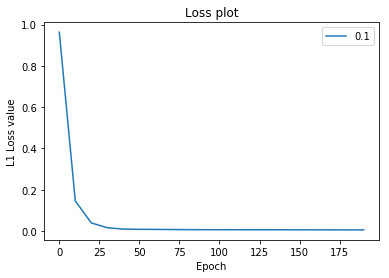



 17%|█▋        | 1/6 [00:15<01:15, 15.07s/it]

L1 Loss value is 0.004028288647532463
Training epoch 180 of 200 complete
L1 Loss value is 0.005304395686835051


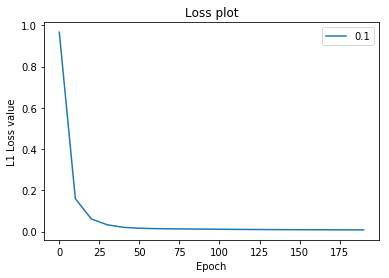

L1 Loss value is 0.012786983512341976
Training epoch 190 of 200 complete


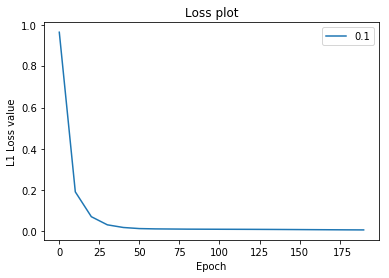



 50%|█████     | 3/6 [00:15<00:31, 10.62s/it]

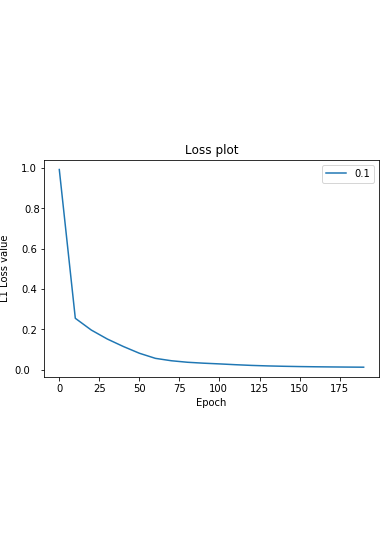

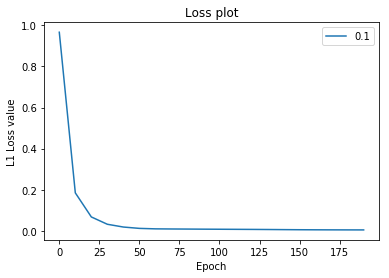



 83%|████████▎ | 5/6 [00:15<00:07,  7.46s/it]

L1 Loss value is 0.015770185738801956


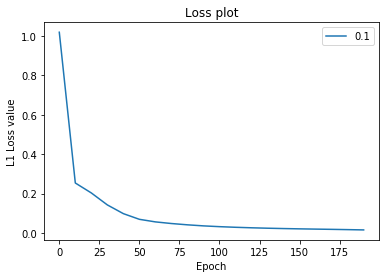



100%|██████████| 6/6 [00:16<00:00,  5.41s/it]



In [318]:
def runner(el_index):
    tr = Variable(torch.from_numpy(trainY[:,el_index].reshape(len(trainY),1)), requires_grad=False).type(torch.FloatTensor)
    model_numpy,epoch,losslog=train_neural_network(one_layer_model(10),epochs=200,learning_rate=0.1,tr_output=tr)
    return model_numpy

import multiprocessing as mp
import tqdm
p=mp.Pool(6)
output=list(tqdm.tqdm(p.imap_unordered(runner,range(6)),total=6))

In [323]:
output[5]

[array([[-1.2909293 ,  1.2728968 ,  0.2002588 , -0.39762816, -0.17961697,
          0.31853506],
        [-1.2196761 , -0.41018683, -0.00851794,  0.03931627,  0.07907491,
          0.37416667],
        [-0.13757457,  0.76606077,  0.9639054 , -0.94708025, -0.6652778 ,
          0.8030041 ],
        [-0.7876821 ,  1.501508  , -0.19103642,  0.29312202,  0.1487382 ,
         -0.00666985],
        [-0.7686567 , -0.14168286,  0.0374262 , -0.1545092 , -0.38769552,
         -1.5054934 ],
        [ 0.18305379,  0.28235018, -1.060523  , -0.34347722, -0.55830926,
          0.10937645],
        [-1.4381517 ,  0.25734812, -0.38305584, -0.05702115,  0.27883947,
         -0.22289346],
        [ 0.03127825,  1.448723  , -0.07221688,  0.02339281,  0.03333595,
          0.1828486 ],
        [-1.0720761 ,  2.4290721 , -0.00783188, -0.03586973,  0.02809694,
          0.2521557 ],
        [ 0.08702832,  0.00975809, -3.5859878 ,  0.07270335,  0.3438844 ,
         -1.1693577 ]], dtype=float32),
 array([-3.22

In [274]:
np.savez("6element_%d_neural_model.npz"%el_index,
            w_array_0=model_numpy[0],
            b_array_0=model_numpy[1],
            w_array_1=model_numpy[2],
            b_array_1=model_numpy[3],
            input_mean=par_mean,
            input_std=par_std,
            output_mean=ab_mean,
            output_std=ab_std)

Now reconstruct neural network:

In [275]:
net_par=np.load("6element_%d_neural_model.npz"%el_index)
w0=np.asmatrix(net_par['w_array_0'])
w1=np.asmatrix(net_par['w_array_1'])
b0=np.asmatrix(net_par['b_array_0']).T
b1=np.asmatrix(net_par['b_array_1']).T
in_mean=net_par['input_mean']
in_std=net_par['input_std']
out_mean=net_par['output_mean']
out_std=net_par['output_std']

In [276]:
test_par=np.array([-2.4 , -2.85, -0.25 ,  0.65,  0.45, 7.3])
test_par_vector=np.asarray([test_par+0.01*u for u in range(4)])

In [277]:
def sigmoid(x):
    return 1./(1.+np.exp(-1.*x))
def net_standard_output(standard_in_par):
    """Return neural network output (in standardized form)"""
    l1=np.matmul(w0,np.asmatrix(standard_in_par).T)+b0
    standard_out=np.matmul(w1,sigmoid(l1))+b1
    return standard_out
def net_output(in_par,ind=el_index):
    """Return physics neural network output for destandardized parameters"""
    # Standardize input:
    standard_in=(in_par-in_mean)/in_std
    # Reconstruct network
    standard_out=net_standard_output(standard_in)
    # Destandardize output
    out = np.asarray(standard_out.T)*out_std[ind]+out_mean[ind]
    return out

Test this works:

In [278]:
net_output(test_par_vector)

array([[0.03623694],
       [0.04021901],
       [0.04400768],
       [0.04761562]])

Run Neural Network on the Test Set

In [279]:
# Load test data:
datT=np.load('/mnt/store1/oliverphilcox/TestPredictions6El.npz')
abunT=datT.f.abundances
elsT=datT.f.elements
paramsT=datT.f.params

bitmapT=np.ones(len(paramsT),dtype=int)
for i,ab in enumerate(abunT):
    if ab[0]==0:
        bitmapT[i]=0
                
# Remove dodgy data
cut_paramsT=paramsT[np.where(bitmapT==1)]
cut_abunsT=abunT[np.where(bitmapT==1)]
good_indexT=np.where(np.isfinite(cut_abunsT[:,0]))[0]
cut_params2T=cut_paramsT[good_indexT]
cut_abuns2T=cut_abunsT[good_indexT]

# Standardize using same standardizations as before
testX=(cut_params2T-par_mean)/par_std
testY=(cut_abuns2T-ab_mean)/ab_std

In [280]:
max(paramsT[:,-1])

13.499607202386068

In [281]:
indices=np.random.randint(0,len(trainX),10000)

In [282]:
len(trainX)

49919

In [283]:
nn_testY=np.asarray(net_standard_output(testX[:]).T)
nn_trainY=np.asarray(net_standard_output(trainX[indices,:]).T)

In [284]:
nn_all_trainY=np.asarray(net_standard_output(trainX).T)

(array([5115., 4919., 5037., 4948., 5097., 5037., 5004., 4923., 4910.,
        4929.]),
 array([-1.72603815, -1.37951146, -1.03298477, -0.68645808, -0.33993139,
         0.0065953 ,  0.35312199,  0.69964868,  1.04617537,  1.39270206,
         1.73922875]),
 <a list of 10 Patch objects>)

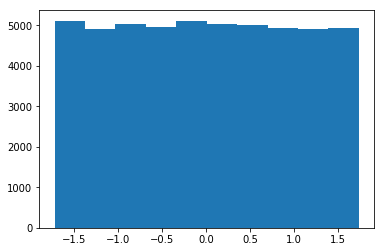

In [285]:
plt.hist(testX[:,-1])

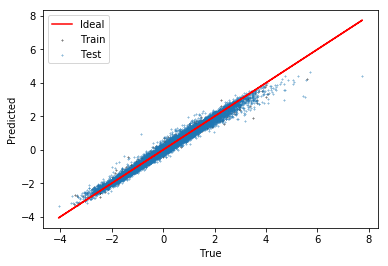

In [286]:
plt.scatter(testY[:5000,el_index],nn_testY[:5000],c='k',marker='x',label='Train',s=1,alpha=0.5)
#plt.scatter(trainY[indices,el_index],nn_trainY[:],c='k',marker='x',label='Train',s=1)
plt.scatter(testY[5000:,el_index],nn_testY[5000:],marker='x',label='Test',s=1,alpha=0.5)
plt.plot(testY[:,el_index],testY[:,el_index],c='r',label='Ideal');plt.legend();
plt.ylabel('Predicted');plt.xlabel('True');

Look at data more carefully:

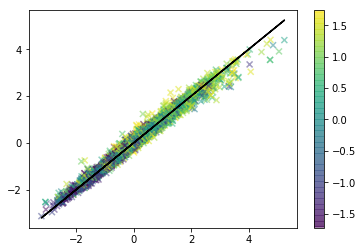

In [287]:
plt.scatter(trainY[indices,el_index],nn_trainY[:],marker='x',alpha=.5,c=trainX[indices,5]);plt.colorbar()
plt.plot(trainY[indices,el_index],trainY[indices,el_index],c='k')

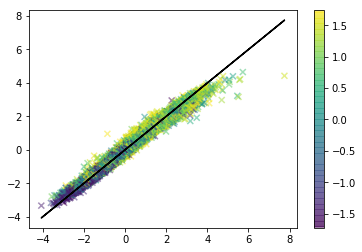

In [289]:
plt.scatter(testY[:,el_index],nn_testY[:,el_index],marker='x',alpha=.5,c=testX[:,5]);plt.colorbar()
plt.plot(testY[:,el_index],testY[:,el_index],c='k')

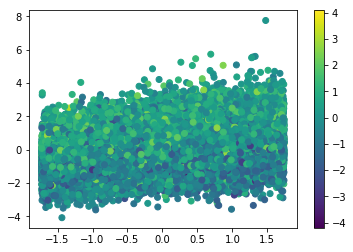

In [290]:
plt.scatter(testX[:,5],testY[:,el_index],c=testX[:,2]);plt.colorbar()

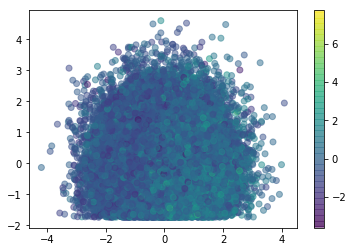

In [291]:
filt=np.where(testX[:,-1]*par_std[-1]+par_mean[-1]>3)
plt.scatter(testX[filt,2],testX[filt,3],c=testY[filt,el_index],alpha=0.5);plt.colorbar()

In [ ]:
from sklearn import cross_validation
from sklearn.neural_network import MLPRegressor

some_indices=np.random.randint(0,len(trainY),10000)

def regressor(neurons):
    """Return out-of-sample score for a given number of neurons"""
    model=MLPRegressor(solver='adam',alpha=0.001,max_iter=1000,learning_rate='adaptive',tol=1e-8,
                       hidden_layer_sizes=(neurons,),activation='tanh')

    model.fit(trainX[some_indices],trainY[some_indices,el_index])

    model_pred=model.predict(testX)
    score = np.mean((model_pred-testY[:,el_index])**2.)
    return score

model=MLPRegressor(solver='adam',alpha=0.001,max_iter=2000,learning_rate='adaptive',tol=1e-8,
                   hidden_layer_sizes=(20,),activation='tanh')

model.fit(trainX[some_indices],trainY[some_indices,el_index])

model_pred=model.predict(testX)


In [295]:
neurons=np.arange(2,30,5)
scores=np.asarray([regressor(n) for n in neurons])

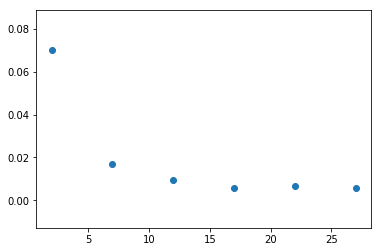

In [297]:
plt.scatter(neurons,scores,label='Tanh')


Text(0.5,0,'Time')

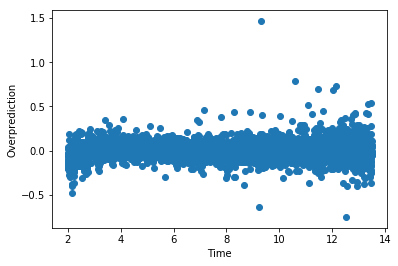

In [301]:
plt.scatter(testX[:10000,5]*par_std[-1]+par_mean[-1],testY[:10000,el_index]-model_pred[:10000])
plt.ylabel('Overprediction')
plt.xlabel('Time')

ValueError: x and y must be the same size

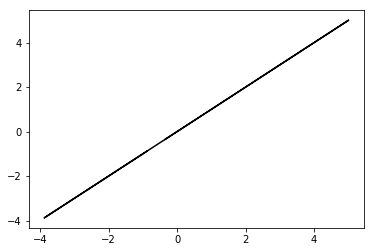

In [302]:
plt.plot(model_pred,model_pred,c='k')
plt.scatter(testY[:10000,el_index],model_pred,c=testX[:10000,5])

In [303]:
all_vals=np.asarray([np.unique(trainX[:,i]) for i in range(6)])


In [304]:
iset=[1,2,5,7,2,7] # which value for each index
which=[0,1,4,5] # indices to contract over
good_ind=[]
for i,tr in enumerate(trainX):
    if tr[which[0]]==all_vals[which[0]][iset[which[0]]]:
        if tr[which[1]]==all_vals[which[1]][iset[which[1]]]:
            if tr[which[2]]==all_vals[which[2]][iset[which[2]]]:
                if tr[which[3]]==all_vals[which[3]][iset[which[3]]]:
                    good_ind.append(i)

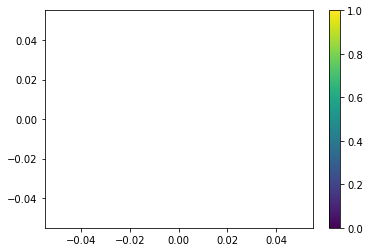

In [305]:
plt.scatter(trainX[good_ind,2],trainX[good_ind,3],c=trainY[good_ind,el_index]);plt.colorbar()

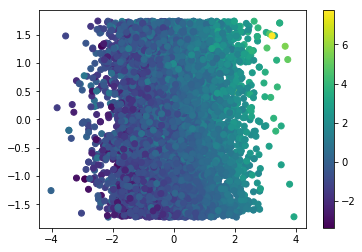

In [306]:
#plt.scatter(testX[:,1],testX[:,5],c=testY[:,el_index],alpha=0.1)
plt.scatter(trainX[some_indices,1],trainX[some_indices,5],c=trainY[some_indices,el_index])
plt.colorbar()